In [47]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from tqdm import tqdm

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.optim as optim
import time

In [48]:
data_dir = 'Dataset'
### With these commands the train and test datasets, respectively, are downloaded
### automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

In [49]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [50]:
m = len(train_dataset)
# m = 60,000

# random_split randomly split a dataset into non-overlapping new datasets of given lengths
# train (48,000 images), val split (12,000 images)
train_data, val_data = random_split(train_dataset, [int(m - m * 0.2), int(m * 0.2)])

batch_size = 256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## 1 Define Encoder and Decoder classes

In [51]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            # nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            # nn.BatchNorm2d(32),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [52]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

## 2 Train model

In [53]:
### Training function
def train_epoch_den(encoder, decoder, device, dataloader, optimizer, val_lambda0=1, val_lambda=1, val_lambdaprime=1):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss1 = []
    train_loss2 = []
    train_loss3 = []
    train_loss = []

    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        x_zeros = torch.zeros_like(image_batch)
        # Encode data (z)
        encoded_data = encoder(image_batch)
        z_zeros = torch.zeros_like(encoded_data)
        # print(torch.var(encoded_data))
        # Decode data (x_hat)
        decoded_data = decoder(encoded_data)
        # Re-encode data (z_hat)
        z_hat = encoder(decoded_data)

        # Evaluate loss
        loss_fn = torch.nn.MSELoss()
        loss1 = loss_fn(image_batch, decoded_data)
        loss2 = loss_fn(encoded_data, z_hat)
        loss3 = loss_fn(encoded_data, z_zeros)
        loss = val_lambda0 * loss1 + val_lambda * loss2 + val_lambdaprime * loss3

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.data))

        train_loss1.append(loss1.detach().cpu().numpy())
        train_loss2.append(loss2.detach().cpu().numpy())
        train_loss3.append(loss3.detach().cpu().numpy())
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss1), np.mean(train_loss2), np.mean(train_loss3), np.mean(train_loss)

In [54]:
### Testing function
def test_epoch_den(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        conc_zeros = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            x_zeros = torch.zeros_like(image_batch)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
            conc_zeros.append(x_zeros.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        conc_zeros = torch.cat(conc_zeros)
        # Evaluate global loss
        lossx = loss_fn(conc_out, conc_label)
        Ex = loss_fn(conc_out, conc_zeros)
        Ex = Ex.detach().cpu().numpy()
        lossx = lossx.detach().cpu().numpy()
        # Calculate SNR_x
        snr_x = 10 * np.log10(Ex / lossx)
    return lossx, snr_x

In [55]:
def plot_ae_outputs(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[i][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()

#### Model of different dimensions

In [ ]:
### Set the random seed for reproducible results
torch.manual_seed(0)

snrs_x = []
rec_batch = []
test_loss = []
### Initialize the two networks
for d in range(4, 101, 4):
    print('d = %d: ' %d)
    encoder = Encoder(encoded_space_dim=d, fc2_input_dim=128)
    decoder = Decoder(encoded_space_dim=d, fc2_input_dim=128)
    ### Define the loss function
    loss_fn = torch.nn.MSELoss()

    ### Define an optimizer (both for the encoder and the decoder!)
    lr = 0.001 # Learning rate

    params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
    ]

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    optim = torch.optim.Adam(params_to_optimize, lr=lr)

    # Move both the encoder and the decoder to the selected device
    encoder.to(device)
    decoder.to(device)

    ### Setting parameters
    num_epochs = 30
    val_lambda0 = 1
    val_lambda = 1
    val_lambdaprime = 1
    loss = []

    for epoch in range(num_epochs):
        ### Training
        train_loss1, train_loss2, train_loss3, train_loss=train_epoch_den(
            encoder=encoder,
            decoder=decoder,
            device=device,
            dataloader=train_loader,
            optimizer=optim,
            val_lambda0=val_lambda0,
            val_lambda=val_lambda,
            val_lambdaprime=val_lambdaprime)

        loss.append(train_loss)
        # Print loss
        print('EPOCH {}/{} \t train loss {:.3f}'.format(epoch+1, num_epochs, train_loss))

        if epoch==num_epochs-1:
            ### Testing
            Test_loss, snr_x = test_epoch_den(
            encoder=encoder,
            decoder=decoder,
            device=device,
            dataloader=test_loader,
            loss_fn=loss_fn)

            snrs_x.append(snr_x)
            test_loss.append(Test_loss)

            prefix = './model/dimension' + '/CAE_dim{}'.format(d)+ '_lmd_{}_{}_{}'.format(val_lambda0, val_lambda, val_lambdaprime) + '_epc{}_'.format(epoch+1)
            name = time.strftime(prefix + '%m%d_%H_%M_%S.pth')
            torch.save([encoder, decoder], name)

    img = test_dataset[0][0].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img = decoder(encoder(img))
    rec_batch.append(rec_img.cpu().squeeze().numpy())

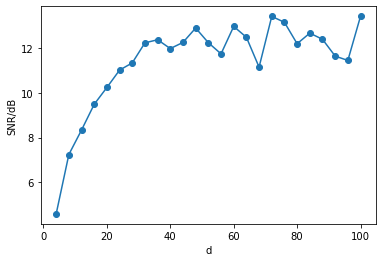

In [57]:
### SNR_x-d
snrs_x = np.array(snrs_x)
dx = np.linspace(4, 100, 25)
plt.plot(dx, snrs_x, marker='o')
plt.xlabel('d')
plt.ylabel('SNR/dB')
plt.show()

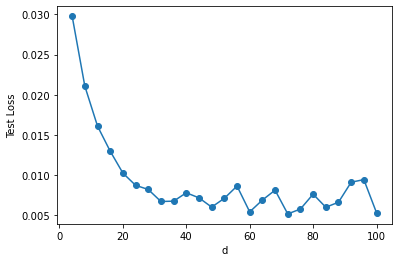

In [58]:
### Test_loss-d
plt.plot(dx, test_loss, marker='o')
plt.xlabel('d')
plt.ylabel('Test Loss')
#plt.savefig('d_testloss')
plt.show()

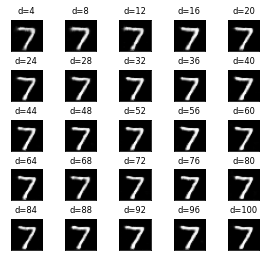

In [59]:
### Rec_img-d
for idx, img in enumerate(rec_batch):
    ax = plt.subplot(5, 5, idx+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('d=%d' %dx[idx], fontsize='small')
    plt.imshow(img, cmap='gist_gray')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.7,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.6)
#plt.savefig('d_recimg')
plt.show()